<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [ ]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install synphot --quiet

     |████████████████████████████████| 914 kB 14.5 MB/s 


# **GitHub**

In [ ]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 1082, done.
remote: Counting objects: 100% (707/707), done.
remote: Compressing objects: 100% (327/327), done.
remote: Total 1082 (delta 387), reused 693 (delta 378), pack-reused 375
Receiving objects: 100% (1082/1082), 169.49 MiB | 24.16 MiB/s, done.
Resolving deltas: 100% (575/575), done.


In [ ]:
cd INSIST/data

/content/INSIST/data


In [ ]:
!cp -a plot.py /usr/local/lib/python3.7/dist-packages/sedfitter

#**Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
from scipy.interpolate import interp1d
from scipy import integrate

import mastcasjobs
from scipy.optimize import minimize_scalar,minimize

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

# **Data**

## **CasJobs Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 28) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **M 31**

In [ ]:
df_M31 = Table.read('/content/INSIST/data/M31_UVIT_PanSTARRS_crossmatch.fits').to_pandas()

In [120]:
df_star = df_M31[df_M31['ps_score']>0.5][:1].copy()
df_star =  df_star.rename(columns = {'raStack':'ra','decStack':'dec'})

In [125]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)                  # Jy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])        # Jy

In [126]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,...,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err
0,157340109227129762,10.922739,41.1243,19.1668,0.006854,19.0145,0.007228,19.201599,0.006759,19.291201,...,0.000078,5.361058e-07,0.00009,6.504959e-07,0.000076,5.119989e-07,0.00007,0.000001,0.000058,0.000002


# **Synthetic Spectra**

## **Synphot**

In [ ]:
os.environ['PYSYN_CDBS'] = '/content/INSIST/data'

In [ ]:
!mkdir '/content/INSIST/data/grid'

In [ ]:
cd '/content/INSIST/data/grid/'

/content/INSIST/data/grid


In [ ]:
!wget http://ssb.stsci.edu/trds/tarfiles/synphot3.tar.gz

In [ ]:
!tar -xf synphot3.tar.gz

In [ ]:
!cp -a /content/INSIST/data/grid/grp/redcat/trds/grid/ck04models /content/INSIST/data/grid/

In [ ]:
!rm -r grp

In [ ]:
cat = Table.read('ck04models/catalog.fits')

In [ ]:
filter_dict = {'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat']}

In [ ]:
wav = Table.read(f'ck04models/ckm05/ckm05_10000.fits')['WAVELENGTH'].value

In [ ]:
df = cat[['INDEX']]
conv_fluxes = []
for f in cat['FILENAME']:
  l = f.split('[')
  name        = l[0]
  col         = l[1][:3]
  tab         = Table.read(f'ck04models/{name}')
  flux        = tab[col].value
  model_func  = interp1d(wav,flux)
  fluxes      = []
  for filter in filter_dict:

    file_name = filter_dict[filter][1]
    filt_dat  = np.loadtxt(f'/content/INSIST/data/{file_name}')

    x         = filt_dat[:,0]
    y         = filt_dat[:,1]

    y         = (y - y.min())/(y.max() - y.min())

    int_c     = integrate.simps(y,x)
    y/=int_c

    x_new = [wav[0]] + list(x) + [wav[-1]]
    y_new = [0]      + list(y) + [0]
    
    filt_func = interp1d(x_new,y_new)
    wav_new   = np.linspace(wav.min(), wav.max(), len(wav))
    filt_flux = model_func(wav_new)*filt_func(wav_new)

    const     = integrate.simps(filt_flux,wav_new)/integrate.simps(filt_func(wav_new), wav_new)

    filt_flux = interp1d(wav_new, filt_flux)    # erg/s.cm2.A

    lambd = filter_dict[filter][0]                            
 
    filt_flux_out = const*(lambd*1e-10)**2/3e8   # erg/s.cm2.Hz

    fluxes.append(filt_flux_out)

  conv_fluxes.append(fluxes)
conv_fluxes = np.array(conv_fluxes)

In [ ]:
for i, filter in enumerate(filter_dict):
  df[filter] = conv_fluxes[:,i]

In [ ]:
df.write('PanSTARRS_UVIT_conv.fits', overwrite = True)

In [ ]:
model_df = df.to_pandas()

In [ ]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - Md*model_flux)/flux_err
  return chi@chi

In [ ]:
model_df.keys().values[1:-3]

array(['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y'], dtype=object)

In [130]:
chi_set = []
for i,row_source in df_star[:1].iterrows():
  flux     = row_source[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux']].values
  flux_err = row_source[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err']].values

  for j, row_model in model_df.iterrows():

    model_flux = row_model[model_df.keys().values[1:-3]].values/1e-23
    
    Md = minimize_scalar(chi2_func,args=(flux,model_flux,flux_err)).x
    
    chi2   = chi2_func(Md,flux,model_flux,flux_err)

    chi_set.append([row_source['objid'],row_model['INDEX'],Md,chi2])

In [128]:
model_flux.values

array([7.53842434971202e-14, 4.517198310554972e-14, 3.817971988954525e-14,
       3.2316134865738187e-14], dtype=object)

In [115]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

In [116]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [118]:
df_chi

,objid,model_name,Md,chi2
0,157340109227129762,"b'10000,-0.5,0.0 '",2.618034,65121.51141
1,157340109227129762,"b'10000,-0.5,0.5 '",2.618034,65121.51141
2,157340109227129762,"b'10000,-0.5,1.0 '",2.618034,65121.51141
3,157340109227129762,"b'10000,-0.5,1.5 '",2.618034,65121.51141
4,157340109227129762,"b'10000,-0.5,2.0 '",0.000000,65121.51141
...,...,...,...,...
6683,157340109227129762,"b'9750,0.5,3.0 '",0.000000,65121.51141
6684,157340109227129762,"b'9750,0.5,3.5 '",0.000000,65121.51141
6685,157340109227129762,"b'9750,0.5,4.0 '",0.000000,65121.51141
6686,157340109227129762,"b'9750,0.5,4.5 '",0.000000,65121.51141


## **SED Fitter**

### **Model**

In [ ]:
if os.path.exists('models_kurucz'):
  os.system('rm -r models_kurucz')

In [ ]:
!curl -o models ftp://ftp.astro.wisc.edu/outgoing/tom/model_packages/models_kurucz_05sep11.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.0M  100 83.0M    0     0  4984k      0  0:00:17  0:00:17 --:--:-- 12.5M


In [ ]:
!tar -xzf models

In [ ]:
!rm models

## **Filters**

Initializing filter parameters using response curves

In [ ]:
filter_dict = {'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat']}

model_dir = 'models_kurucz'
filter_list = []
for filter in filter_dict.keys():

  filt_obj = sed.filter.Filter()
  filt_obj.name = filter
  filt_obj.central_wavelength = (filter_dict[filter][0]*u.angstrom).to(u.micron)
  filt_obj_wl, filt_obj_rsr = np.loadtxt(filter_dict[filter][1], usecols=(0, 1), unpack=True)
  filt_obj.nu = 3.0e18 * u.Hz / np.flip(filt_obj_wl)
  filt_obj_rsr = np.flip(filt_obj_rsr)
  filt_obj.response = filt_obj_rsr/filt_obj_rsr.max() 
  filt_obj.normalize()
  filter_list.append(filt_obj)

Convolving filters with models

In [ ]:
sed.convolve.convolve_model_dir(model_dir, filter_list)

INFO: 3808 SEDs found in models_kurucz [sedfitter.convolve.convolve]
INFO: Rebinning filters [sedfitter.convolve.convolve]


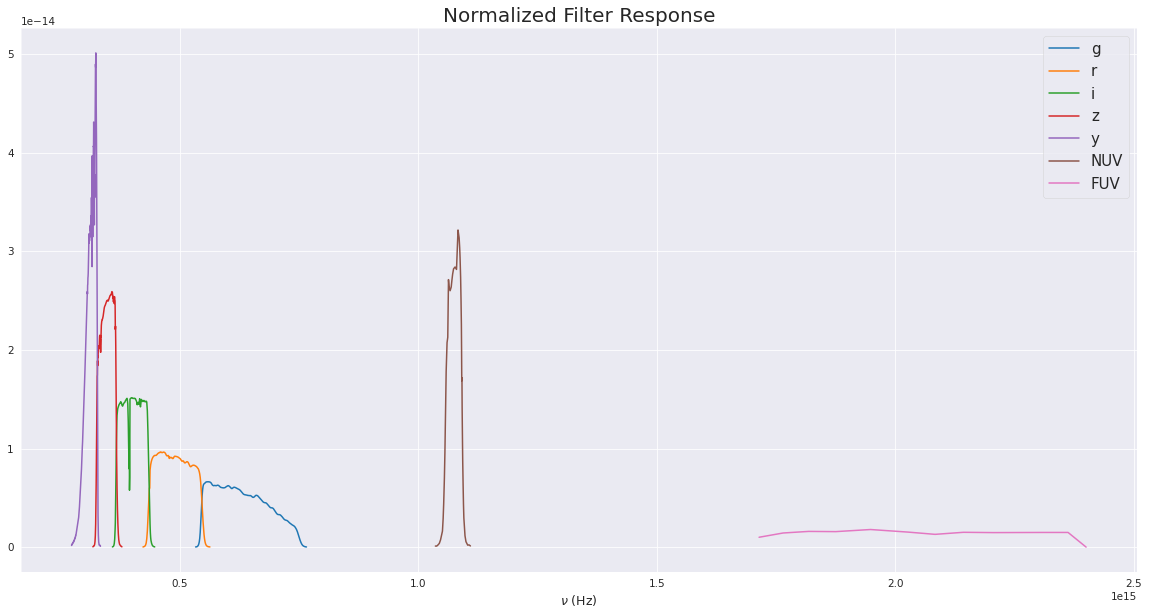

In [ ]:
plt.figure(figsize = (20,10))
for filter in filter_list:
  plt.plot(filter.nu, filter.response)

plt.xlabel(r'$\nu$ (Hz)')
plt.title('Normalized Filter Response',size=20)
plt.legend(['g','r','i','z','y' ,'NUV','FUV'])


# **SED Fitting**

### **SED Fitter**

#### **Without UV**

In [ ]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

df_star['g_flag']  = 1
df_star['i_flag']  = 1
df_star['r_flag']  = 1
df_star['z_flag']  = 1
df_star['y_flag']  = 1

df_star = df_star.drop_duplicates('objid')

df_out = df_star[['objid', 'ra', 'dec','g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

df_out.to_csv('data_input.dat', sep = " ",index=False, header=False)

In [ ]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
d = sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 40.],output_convolved=True)


Extracting fitting parameters from SED Fitter output

In [ ]:
from sedfitter import plot
plot('output.fitinfo', 'plots_seds',format='png' , dpi = 1024)

In [ ]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 


flux     = []
flux_err = []
chi2     = []
Avs      = []
scs      = []

model_names = []
for info in fin:
  Avs.append(info.av[0])
  scs.append(info.sc[0])
  model_name = info.model_name[0]
  model_names.append(model_name)
  chi2.append(info.chi2[0])

  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1],g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

Avs = np.array(Avs)

scs = np.array(scs)

Text(0.5, 1.0, 'SED Fitter')

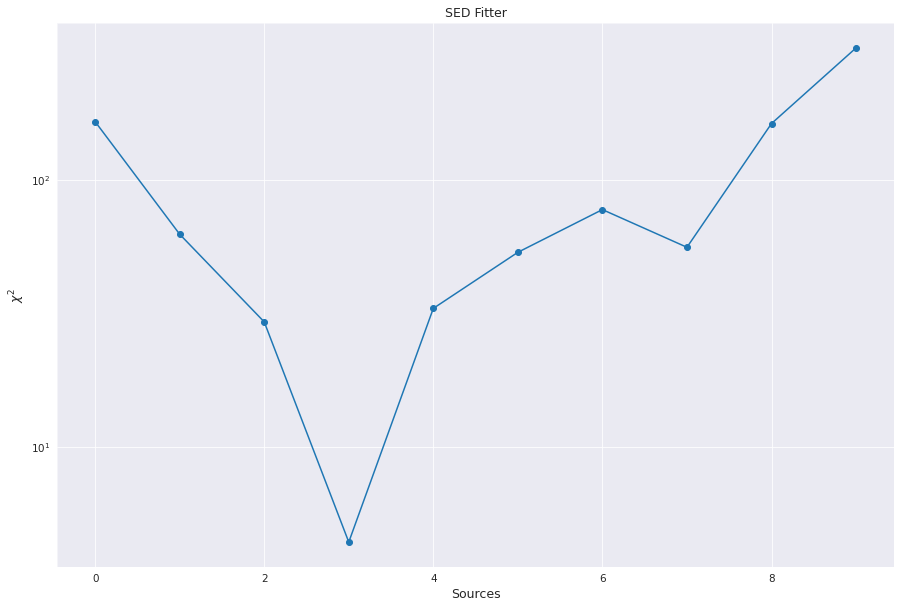

In [ ]:
plt.plot(chi2,'o-')
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

#### **With UV**

In [ ]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy


df_star['FUVFlux'] = 3631*pow(10,-df_star['ABmag1']/2.5)*1000 
df_star['FUVFlux_err'] = (df_star['Errmag1']*df_star['FUVFlux'])/1.09  #mJy 

df_star['NUVFlux'] = 3631*pow(10,-df_star['ABmag2']/2.5)*1000 
df_star['NUVFlux_err'] = (df_star['Errmag2']*df_star['NUVFlux'])/1.09  #mJy 

df_star['fuv_flag']  = 1
df_star['nuv_flag']  = 1
df_star['g_flag']  = 1
df_star['i_flag']  = 1
df_star['r_flag']  = 1
df_star['z_flag']  = 1
df_star['y_flag']  = 1

df_star = df_star.drop_duplicates('objid')

df_out = df_star[['objid', 'ra', 'dec','fuv_flag','nuv_flag','g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','FUVFlux','FUVFlux_err','NUVFlux','NUVFlux_err','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

df_out.to_csv('data_input.dat', sep = " ",index=False, header=False)

In [ ]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['UVIT_FUV', 'UVIT_NUV','PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3,3,3,3,3,3,3] * u.arcsec

# Run the fitting
d = sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 10.],output_convolved=True)

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  Kurucz stellar photospheres
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading models_kurucz/convolved/UVIT_FUV.fits
   Reading models_kurucz/convolved/UVIT_NUV.fits
   Reading models_kurucz/convolved/PS1g.fits
   Reading models_kurucz/convolved/PS1r.fits
   Reading models_kurucz/convolved/PS1i.fits
   Reading models_kurucz/convolved/PS1z.fits
   Reading models_kurucz/convolved/PS1y.fits
 ------------------------------------------------------------
  => Fitting parameters
 ------------------------------------------------------------

   Minimum A_V      :     0.000 mag
   Maximum A_V      :    10.000 mag
   Minimum distance :     0.010 Mpc
   Maximum distance :     2.0


Extracting fitting parameters from SED Fitter output

In [ ]:
from sedfitter import plot
plot('output.fitinfo', 'plots_seds_UV',format='png' , dpi = 1024)

In [ ]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')


FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 
NUV = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1) 

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)

flux     = []
flux_err = []
chi2     = []
Avs      = []
scs      = []

model_names = []
for info in fin:
  Avs.append([info.av[0]]*7)
  scs.append([info.sc[0]]*7)
  model_name = info.model_name[0]
  model_names.append(model_name)
  chi2.append(info.chi2[0])

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  nuv =[NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]


  flux.append([fuv[0], nuv[0],  g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1], nuv[1], g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

Avs = np.array(Avs)

scs = np.array(scs)

Text(0.5, 1.0, 'SED Fitter')

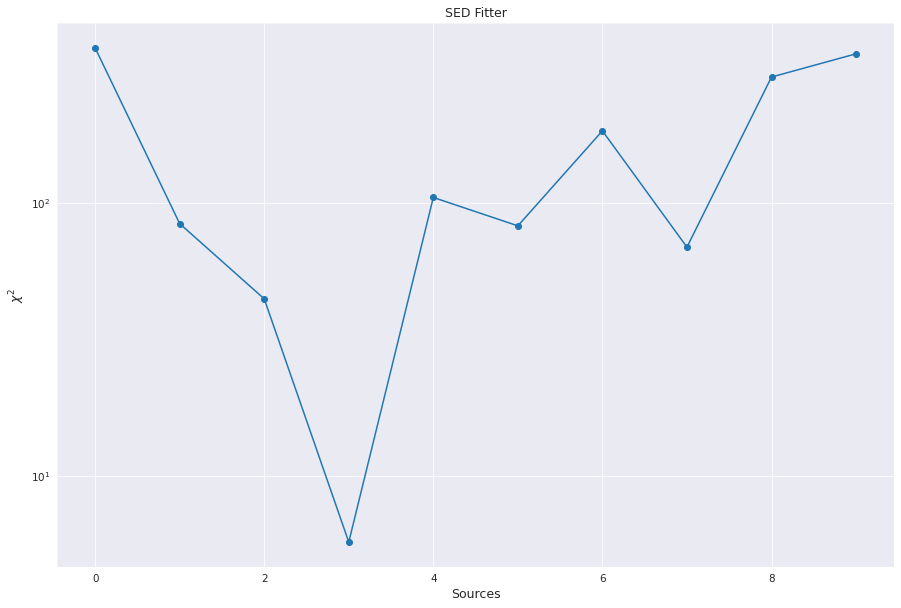

In [ ]:
plt.plot(chi2,'o-')
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

In [ ]:
l = ['157340109227129762','157380109682042534','157390108898417576','157350108218814598','157380109152072565']

Text(0.5, 0.98, 'Left: Without UV | Right : With UV')

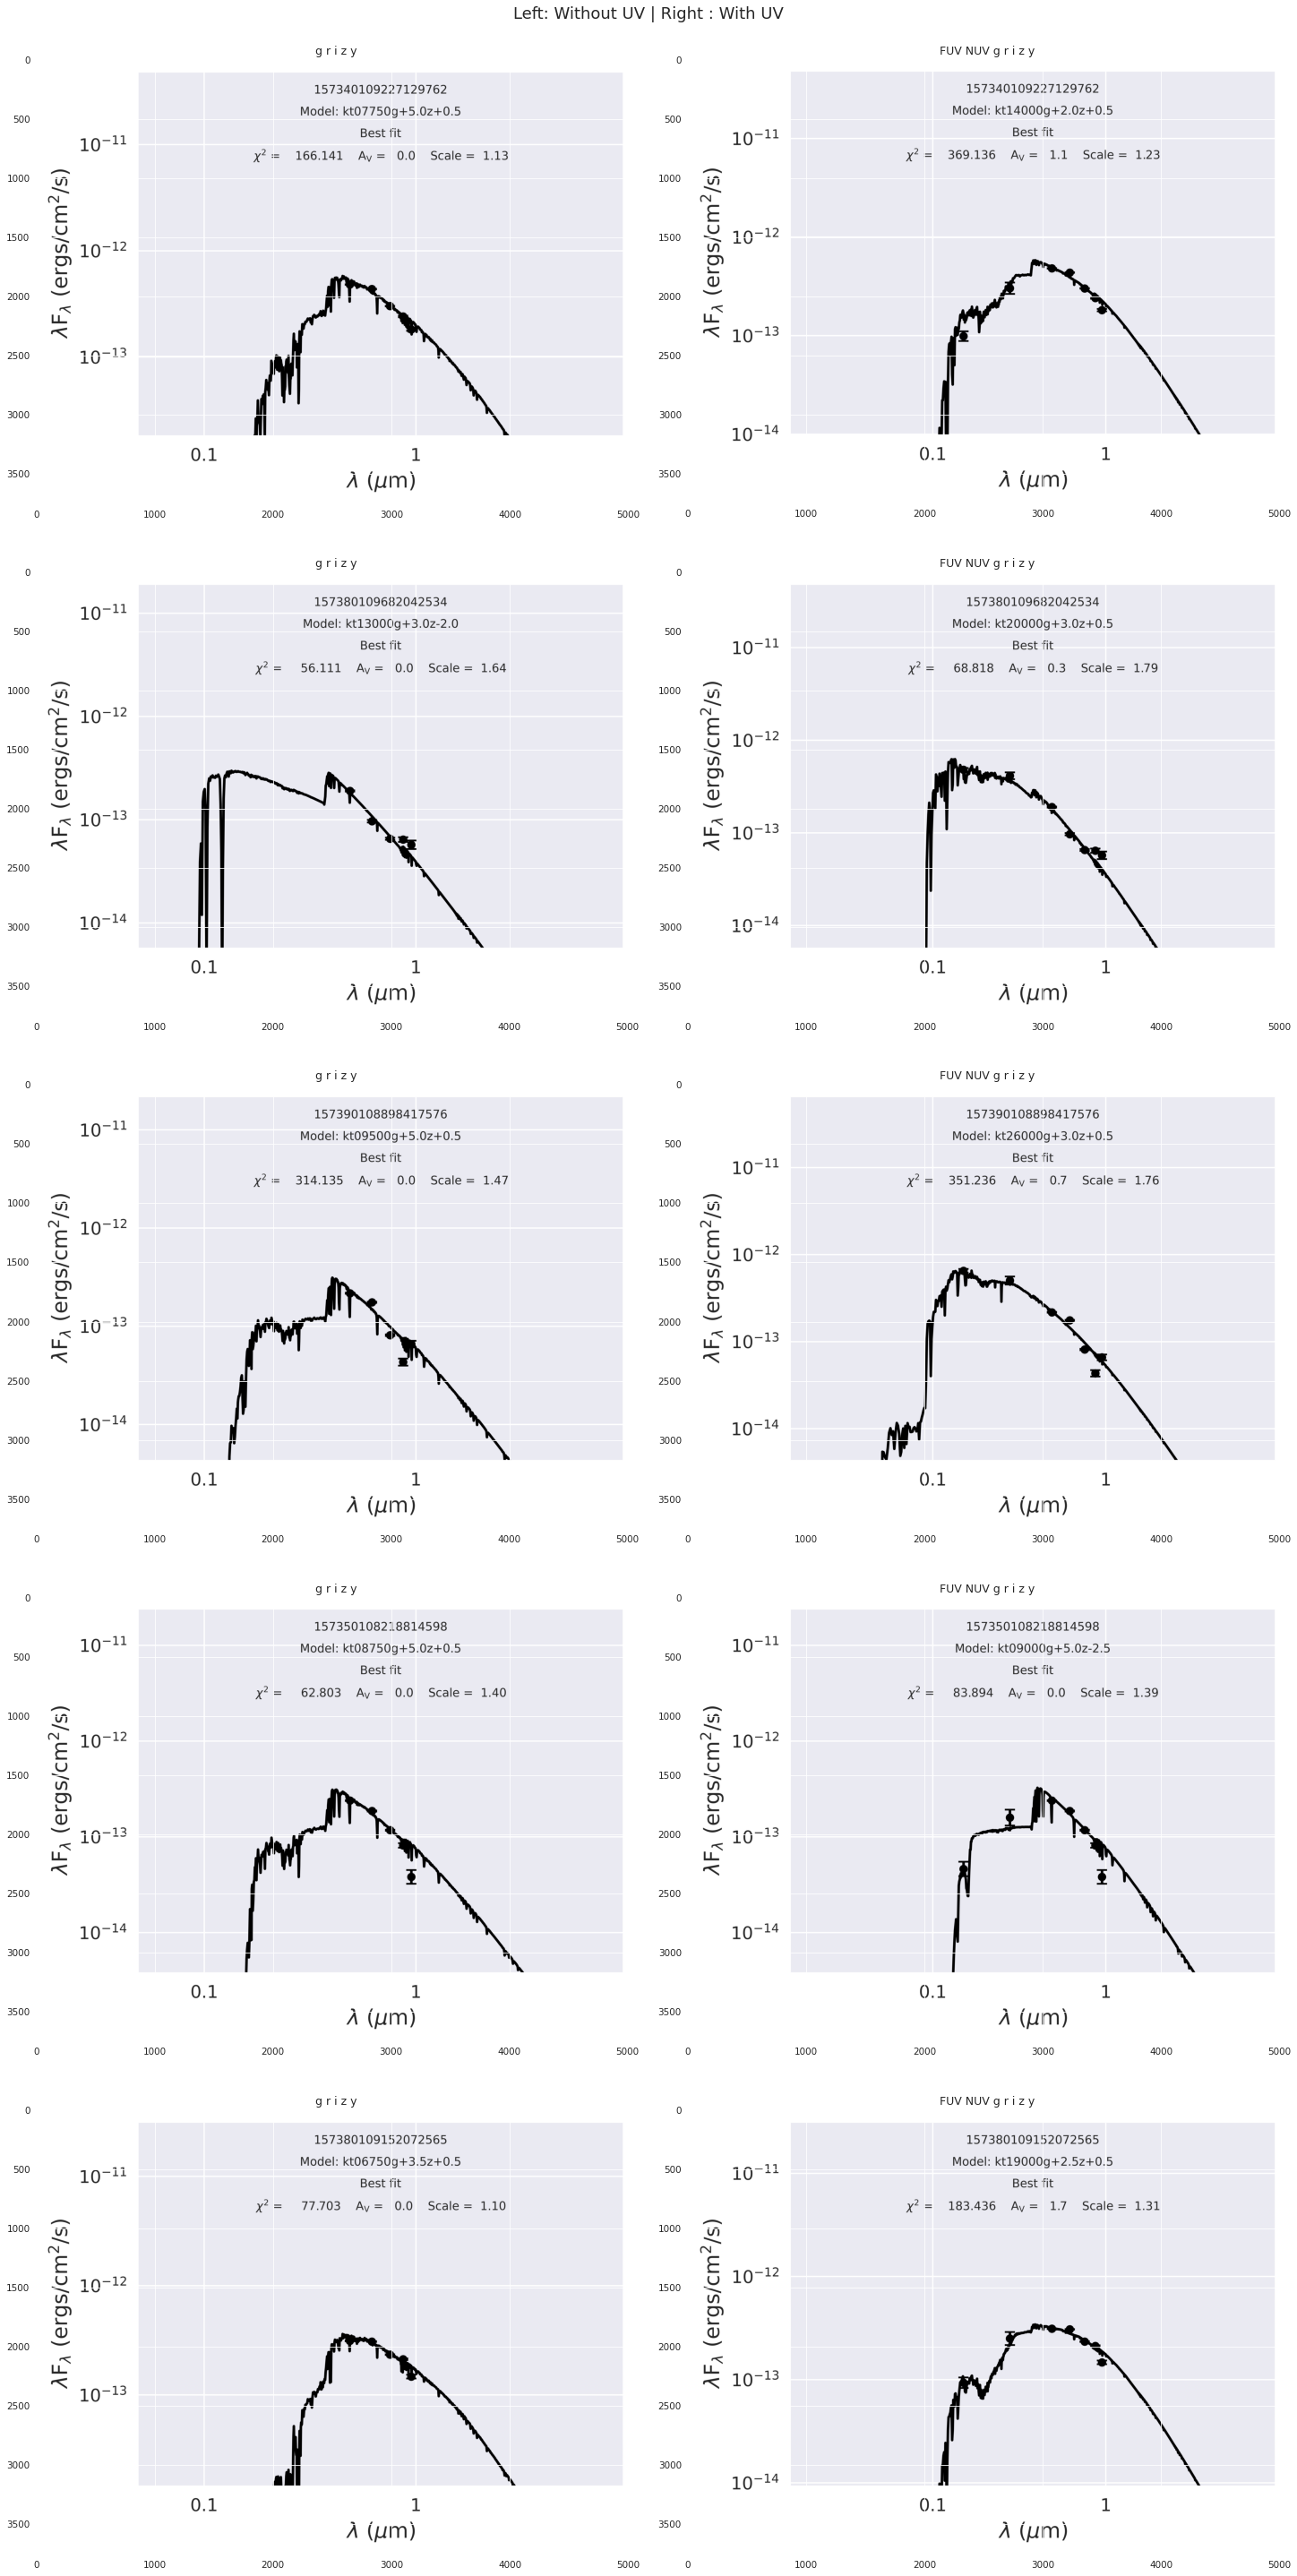

In [ ]:
fig,ax = plt.subplots(5,2,figsize = (20,40),constrained_layout=True)

for i,fn in enumerate(l):
  img = plt.imread(f'plots_seds/{fn}.png')
  ax[i,0].imshow(img)
  ax[i,0].set_title('g r i z y')
  img = plt.imread(f'plots_seds_UV/{fn}.png')
  ax[i,1].imshow(img)
  ax[i,1].set_title('FUV NUV g r i z y')
fig.suptitle('Left: Without UV | Right : With UV')

### **SED Fitting Routine**

EMCEE : Bayesian. 

#### **Without UV**

In [ ]:
df_star = df_star.reset_index()

In [ ]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

##### **Without Av**

In [ ]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - Md*model_flux)/flux_err
  return chi@chi

In [ ]:
# Convolved Filters

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4)):
    model_flux = np.array(model_flux)
    
    Md = minimize_scalar(chi2_func,args=(flux,model_flux,flux_err)).x
    
    chi2   = chi2_func(Md,flux,model_flux,flux_err)
    chi_set.append([row['objid'],model_name[j],Md,chi2])

In [ ]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

In [ ]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [ ]:
df_chi_min 

,objid,model_name,Md,chi2
1434,157340109227129762,kt07500g+4.5z+0.5,0.006007,129.188182
5594,157350108218814598,kt08750g+5.0z+0.5,0.001600,42.080573
8994,157370109140545982,kt07500g+1.0z+0.5,0.004211,11.711089
13330,157370109233994618,kt09250g+5.0z+0.5,0.000810,2.865534
18642,157380108253555129,kt30000g+5.0z+0.5,0.000122,33.548876
20910,157380109041666548,kt09250g+2.5z-2.0,0.000661,27.096881
23914,157380109152072565,kt06500g+1.5z+0.5,0.007069,39.765395
29486,157380109682042534,kt16000g+3.0z-2.0,0.000360,39.190511
31594,157390108841348391,kt06750g+0.5z+0.5,0.004714,145.152360
36402,157390108898417576,kt10250g+5.0z+0.5,0.000927,315.386455


In [ ]:
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 
NUV = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1) 
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)


flux     = []
flux_err = []
Mds      = []
model_names = []
for i,row in df_chi_min.iterrows():
  model_name = row['model_name']
  Md         = row['Md']

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  nuv =[NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], nuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1], nuv[1], g[1], r[1], i[1], z[1], y[1]])

  Mds.append(Md)

flux = np.array(flux)

flux_err = np.array(flux_err)

Mds = np.array(Mds)

In [ ]:
df_star['FUVmag_pred'] = -2.5*np.log10((flux[:,0]*Mds)/3631e3)

df_star['NUVmag_pred'] = -2.5*np.log10((flux[:,1]*Mds)/3631e3)

df_star['chi2'] = df_chi_min['chi2'].values

Text(0.5, 1.0, 'Without Av')

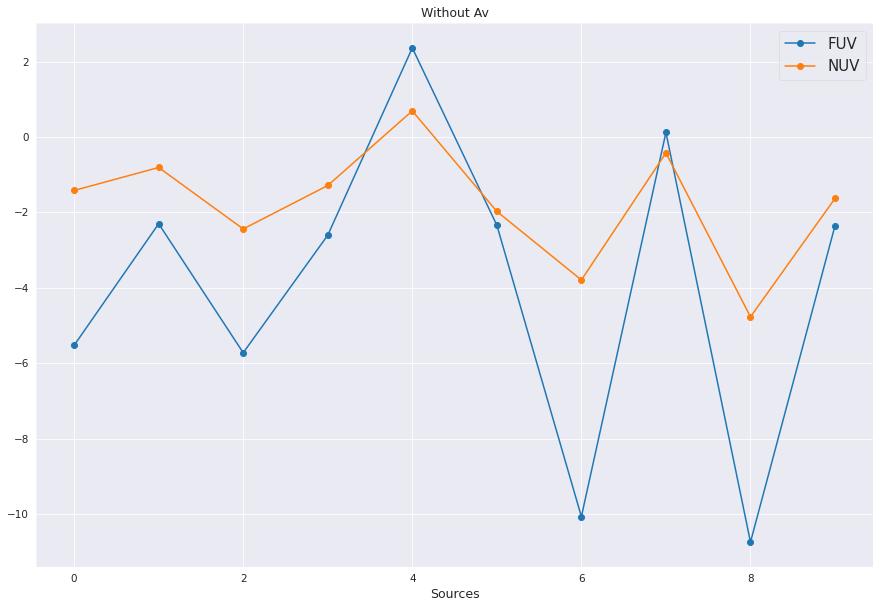

In [ ]:
diff = df_star['ABmag1'] - df_star['FUVmag_pred']
plt.plot(diff,'o-')

diff = df_star['ABmag2'] - df_star['NUVmag_pred']

plt.plot(diff,'o-')

plt.legend(['FUV','NUV'])

plt.xlabel('Sources')

plt.title('Without Av')

In [ ]:
df_star[['objid','ABmag1','FUVmag_pred','ABmag2','NUVmag_pred','chi2']]

,objid,ABmag1,FUVmag_pred,ABmag2,NUVmag_pred,chi2
0,157340109227129762,22.156,27.682612,20.267,21.685585,129.188182
1,157350108218814598,22.973,25.274757,20.959,21.767460,42.080573
2,157370109140545982,21.984,27.707778,20.669,23.108514,11.711089
3,157370109233994618,21.955,24.560651,20.833,22.119675,2.865534
4,157380108253555129,21.068,18.704944,19.989,19.296730,33.548876
5,157380109041666548,20.982,23.321835,20.423,22.396773,27.096881
6,157380109152072565,22.216,32.286424,20.471,24.264151,39.765395
7,157380109682042534,20.445,20.324139,19.935,20.358100,39.190511
8,157390108841348391,20.654,31.399739,19.753,24.523585,145.152360
9,157390108898417576,20.115,22.467006,19.719,21.347925,315.386455


##### **With Av**

$\chi^2 =\dfrac{1}{N - n_p}\sum\limits_{i=1}^j\left(\dfrac{Y_{i,o} -M_d \times Y_{i,M}\times10^{-0.4\times ext_i\times A_v}}{\sigma_{i,o}}\right)^2$

In [ ]:
def chi2_func(params,flux,model_flux,flux_err,ext):
  Md, av = params
  chi = (flux - Md*model_flux*pow(10,-0.4*av*ext))/flux_err
  return chi@chi

In [ ]:
# Convolved Filters

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
ext = np.array([1.18, 0.881, 0.667, 0.534,0.457])
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux', 'yPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)
    
    params = minimize(chi2_func,x0 = (1e-2,0.5),bounds=([0,np.inf],[0,np.inf]),args=(flux,model_flux,flux_err,ext)).x
    Md, Av = params
    chi2   = chi2_func(params,flux,model_flux,flux_err,ext)
    chi_set.append([row['objid'],model_name[j],Md,Av,chi2])

In [ ]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','Av','chi2'])

In [ ]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [ ]:
df_chi_min 

,objid,model_name,Md,Av,chi2
1514,157340109227129762,kt07750g+5.0z+0.5,0.005458,0.011774,163.507443
5594,157350108218814598,kt08750g+5.0z+0.5,0.001595,0.000000,81.514517
9210,157370109140545982,kt08250g+1.0z+0.5,0.003258,0.036439,33.166431
14842,157370109233994618,kt31000g+3.5z+0.5,0.000183,0.859586,4.119895
18674,157380108253555129,kt31000g+5.0z+0.5,0.000114,0.000092,48.453917
20655,157380109041666548,kt08250g+2.0z-2.5,0.000901,0.000000,49.071020
24130,157380109152072565,kt07000g+5.0z+0.5,0.005743,0.035046,79.281452
29438,157380109682042534,kt15000g+3.0z-2.0,0.000403,0.000000,50.107667
31834,157390108841348391,kt07500g+0.5z+0.5,0.003974,0.254648,156.384746
36402,157390108898417576,kt10250g+5.0z+0.5,0.000928,0.000000,317.702866


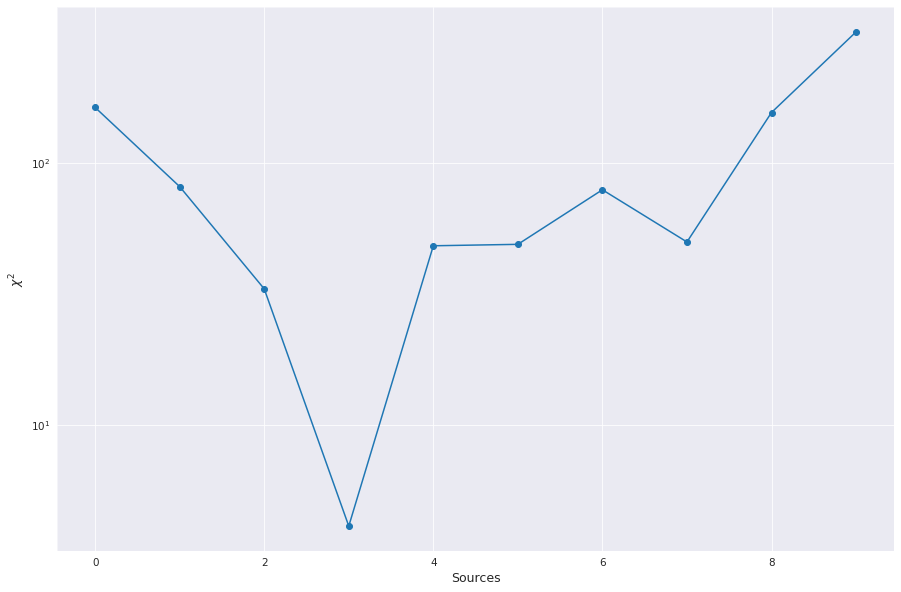

In [ ]:
plt.plot(df_chi_min['chi2'].values,'o-')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.yscale('log')

In [ ]:
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 
NUV = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1) 
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)


flux        = []
flux_err    = []
model_names = []
Mds         = []
for i,row in df_chi_min.iterrows():
  model_name = row['model_name']

  Md         = row['Md']

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  nuv =[NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], nuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1], nuv[1], g[1], r[1], i[1], z[1], y[1]])

  Mds.append(Md)

flux = np.array(flux)

flux_err = np.array(flux_err)

Mds = np.array(Mds)

In [ ]:
df_star['FUVmag_pred'] = -2.5*np.log10((flux[:,0]*Mds*pow(10,-0.4*2.67*df_chi_min['Av'].values))/3631e3)

df_star['NUVmag_pred'] = -2.5*np.log10((flux[:,1]*Mds*pow(10,-0.4*1.95*df_chi_min['Av'].values))/3631e3)

df_star['chi2'] = df_chi_min['chi2'].values

In [ ]:
df_star[['objid','ABmag1','FUVmag_pred','ABmag2','NUVmag_pred']]

,objid,ABmag1,FUVmag_pred,ABmag2,NUVmag_pred
0,157340109227129762,22.156,27.078961,20.267,21.416396
1,157350108218814598,22.973,25.278756,20.959,21.771458
2,157370109140545982,21.984,24.487151,20.669,22.001637
3,157370109233994618,21.955,20.554050,20.833,20.310166
4,157380108253555129,21.068,18.644515,19.989,19.264713
5,157380109041666548,20.982,24.537468,20.423,22.890511
6,157380109152072565,22.216,30.139127,20.471,22.422554
7,157380109682042534,20.445,20.535069,19.935,20.492146
8,157390108841348391,20.654,27.815670,19.753,23.559156
9,157390108898417576,20.115,22.465812,19.719,21.346730


Text(0.5, 1.0, 'With Av')

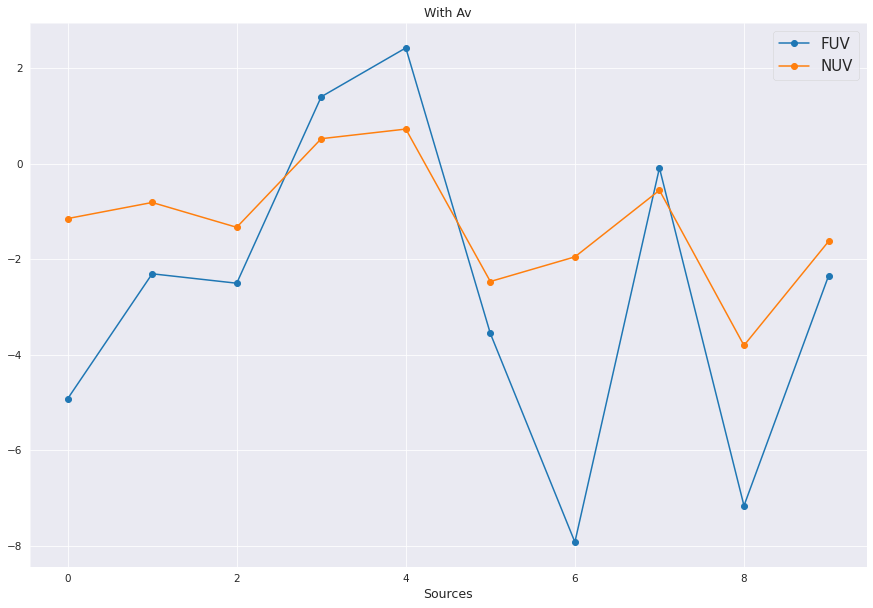

In [ ]:
diff = df_star['ABmag1'] - df_star['FUVmag_pred']
plt.plot(diff,'o-')

diff = df_star['ABmag2'] - df_star['NUVmag_pred']

plt.plot(diff,'o-')

plt.legend(['FUV','NUV'])


plt.xlabel('Sources')

plt.title('With Av')

#### **With UV**

In [ ]:
df_star = df_M31[df_M31['ps_score']>0.5][:10].copy()
df_star =  df_star.rename(columns = {'raStack':'ra','decStack':'dec'})

In [ ]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

df_star['FUVFlux'] = 3631*pow(10,-df_star['ABmag1']/2.5)*1000 
df_star['FUVFlux_err'] = (df_star['Errmag1']*df_star['FUVFlux'])/1.09  #mJy 

df_star['NUVFlux'] = 3631*pow(10,-df_star['ABmag2']/2.5)*1000 
df_star['NUVFlux_err'] = (df_star['Errmag2']*df_star['NUVFlux'])/1.09  #mJy 

##### **Without Av**

In [ ]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - Md*model_flux)/flux_err
  return chi@chi

In [ ]:
# Convolved Filters

fuv = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
nuv = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['FUVFlux','NUVFlux','gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux','yPSFFlux']].values
  flux_err = row[['FUVFlux_err','NUVFlux_err','gPSFFlux_err',  'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(fuv,nuv,f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)
    
    Md = minimize_scalar(chi2_func,args=(flux,model_flux,flux_err)).x
    
    chi2   = chi2_func(Md,flux,model_flux,flux_err)
    chi_set.append([row['objid'],model_name[j],Md,chi2])

In [ ]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

In [ ]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [ ]:
df_chi_min 

,objid,model_name,Md,chi2
1514,157340109227129762,kt07750g+5.0z+0.5,0.005407,263.422705
5663,157350108218814598,kt09000g+5.0z-2.5,0.001629,101.985217
9407,157370109140545982,kt08750g+5.0z-2.5,0.002960,91.538836
13679,157370109233994618,kt11000g+2.0z-2.5,0.000626,26.546198
17970,157380108253555129,kt14000g+3.5z+0.5,0.000433,154.423458
21815,157380109041666548,kt15000g+2.5z-2.5,0.000269,92.263099
24130,157380109152072565,kt07000g+5.0z+0.5,0.005584,186.000414
29521,157380109682042534,kt17000g+2.5z+0.2,0.000286,58.929088
31978,157390108841348391,kt07750g+5.0z+0.5,0.003015,495.231572
37093,157390108898417576,kt16000g+2.5z-1.5,0.000454,385.695704


##### **With Av**

$\chi^2 =\dfrac{1}{N - n_p}\sum\limits_{i=1}^j\left(\dfrac{Y_{i,o} -M_d \times Y_{i,M}\times10^{-0.4\times ext_i\times A_v}}{\sigma_{i,o}}\right)^2$

In [ ]:
def chi2_func(params,flux,model_flux,flux_err,ext):
  Md, av = params
  chi = (flux - Md*model_flux*pow(10,-0.4*av*ext))/flux_err
  return chi@chi

In [ ]:
# Convolved Filters


fuv = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
nuv = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
ext = np.array([2.67,1.95, 1.18, 0.881, 0.667, 0.534,0.457])
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['FUVFlux','NUVFlux','gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux','yPSFFlux']].values
  flux_err = row[['FUVFlux_err','NUVFlux_err','gPSFFlux_err',  'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(fuv,nuv,f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)
    
    params = minimize(chi2_func,x0 = (1e-2,0.5),bounds=([0,np.inf],[0,np.inf]),args=(flux,model_flux,flux_err,ext)).x
    Md, Av = params
    chi2   = chi2_func(params,flux,model_flux,flux_err,ext)
    chi_set.append([row['objid'],model_name[j],Md,Av,chi2])

In [ ]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','Av','chi2'])

In [ ]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [ ]:
df_chi_min 

,objid,model_name,Md,Av,chi2
1514,157340109227129762,kt07750g+5.0z+0.5,0.005442,0.008087,263.174917
5663,157350108218814598,kt09000g+5.0z-2.5,0.001639,0.007097,101.934111
9978,157370109140545982,kt11500g+2.0z+0.5,0.002225,0.502804,42.476191
14138,157370109233994618,kt14000g+2.0z+0.5,0.000486,0.357264,5.908130
17970,157380108253555129,kt14000g+3.5z+0.5,0.000433,0.000000,154.423458
22298,157380109041666548,kt26000g+3.5z+0.5,0.000178,0.757146,65.993708
25810,157380109152072565,kt19000g+2.5z+0.5,0.002312,1.653586,149.723738
29570,157380109682042534,kt18000g+2.5z+0.5,0.000262,0.053402,57.938705
33930,157390108841348391,kt32000g+5.0z+0.5,0.000763,1.595344,238.452884
37482,157390108898417576,kt25000g+3.0z+0.5,0.000289,0.547760,332.189277


In [ ]:
plt.plot(df_chi_min['chi2'].values,'o-')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.yscale('log')

# **Predicting using SED Fitting**

In [ ]:
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 
NUV = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1) 
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)


flux     = []
flux_err = []
model_names = []
for i,row in df_chi_min.iterrows():
  model_name = row['model_name']

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  nuv =[NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , NUV[NUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], nuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1], nuv[1], g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

In [ ]:
tab_star = Table.from_pandas(df_star)

tab_star['model_flux']     = flux
tab_star['Md']             = df_chi_min['Md']
tab_star['Av']             = df_chi_min['Av']

model_mag = []
ext = np.array([2.67,1.95, 1.18, 0.881, 0.667, 0.534,0.457])

for row in tab_star:
  Av = row['Av']
  Md = row['Md']
  model_flux = row['model_flux']

  model_mag.append(-2.5*np.log10(Md*model_flux*pow(10,-0.4*ext*Av)/3631e3))

tab_star['model_mag']  = model_mag
tab_star['chi2'] = df_chi_min['chi2']

In [ ]:
filters = ['ABmag1','ABmag2','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

x = ['FUV', 'NUV', 'gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

FUV_diff = []
FUV_obs = []

NUV_diff = []
NUV_obs = []
for i,fl in df_star[filters].iterrows():
  #plt.plot(x,fl, 'o-', color = 'black')
  #plt.plot(x,tab_star['model_mag'].value[i],'s--')
  FUV_obs.append(fl[0])
  FUV_diff.append(fl[0] - tab_star['model_mag'].value[i][0])

  NUV_obs.append(fl[1])
  NUV_diff.append(fl[1] - tab_star['model_mag'].value[i][1])
 # plt.legend(['Observed','Model'])
 # plt.show()

In [ ]:
plt.scatter(FUV_obs,FUV_diff)
plt.ylabel('FUV (Observed - Predicted )')
plt.xlabel('FUV observed')
plt.title('SED Fitting with Md and Av')


In [ ]:
plt.scatter(NUV_obs,NUV_diff)
plt.ylabel('NUV (Observed - Predicted )')
plt.xlabel('NUV observed')
plt.title('SED Fitting with Md and Av')


In [ ]:
df_chi_min['chi2']